# Global Map of Vessel Categories

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
# from scipy import stats

In [3]:
import bq  
client = bq.Client.Get()

In [4]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer


In [5]:
q = '''SELECT
  max_label_label,
  SUM(IF(max_label_score>= .8,1,0)) high_confidence,
  SUM(IF(max_label_score< .8,1,0)) low_confidence
FROM
  [scratch_global_fishing_raster.classification_results_20160630]
GROUP BY
  max_label_label'''
label_number = Query(q)
labels = [l[0] for l in label_number]
print labels

Waiting on bqjob_r2246749691f7e800_00000155a79fd426_1 ... (0s) Current status: DONE   
Query time: 3.11484289169 seconds.
[u'Passenger', u'Trawler', u'Purse seine', u'Cargo/Tanker', u'Tug/Pilot/Supply', u'Longliner', u'Pots and traps', u'Seismic vessel']


In [12]:
vesselType = 'Passenger'
q = '''
SELECT
  integer(FLOOR(lat*2)) lat_bin,
  integer(FLOOR(lon*2)) lon_bin,
  SUM(IF(last_timestamp IS NOT NULL, (timestamp-last_timestamp)/3600000000, (timestamp - TIMESTAMP(DATE(timestamp)))/3600000000)/2 + IF(next_timestamp IS NOT NULL, (next_timestamp - timestamp)/3600000000, ( TIMESTAMP(DATE(timestamp))- timestamp)/3600000000 +24 )/2) hours
FROM (
  SELECT
    lat,
    lon,
    mmsi,
    timestamp,
    last_timestamp,
    next_timestamp,
    seg_id
  FROM
    TABLE_DATE_RANGE([pipeline_classify_logistic_661b_bined.], TIMESTAMP("2015-01-01"), TIMESTAMP("2015-01-31")))
WHERE
  seg_id NOT IN (
  SELECT
    seg_id
  FROM
    [scratch_david_seg_analysis_661b.2015_segments]
  WHERE
    (point_count<20
      AND terrestrial_positions = point_count)
    OR ((min_lon >= 0 // these are almost definitely noise
        AND max_lon <= 0.109225)
      OR (min_lat >= 0
        AND max_lat <= 0.109225) ))
  AND mmsi IN (
  SELECT
    integer(mmsi) mmsi
  FROM
    [scratch_global_fishing_raster.classification_results_20160630]
  WHERE
    max_label_score>.8
    AND max_label_label = "'''+vesselType+'''" )
  AND lat < 90
  AND lat > -90
  AND lon > -180
  AND lon < 180
GROUP BY
  lat_bin,
  lon_bin
'''

vessel_grid_query = Query(q)

Waiting on bqjob_r7411514c9c351af1_00000155a7b65837_4 ... (109s) Current status: DONE   
Query time: 112.710263968 seconds.


In [13]:
cellsize = .5
one_over_cellsize = 2
max_lat = 90
min_lat = -90
min_lon = -180
max_lon = 180

num_lats = (max_lat-min_lat)*one_over_cellsize
num_lons = (max_lon-min_lon)*one_over_cellsize

grid = np.zeros(shape=(num_lats,num_lons))

for row in vessel_grid_query:
    lat = int(float(row[0]))
    lon = int(float(row[1]))
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = float(row[2])

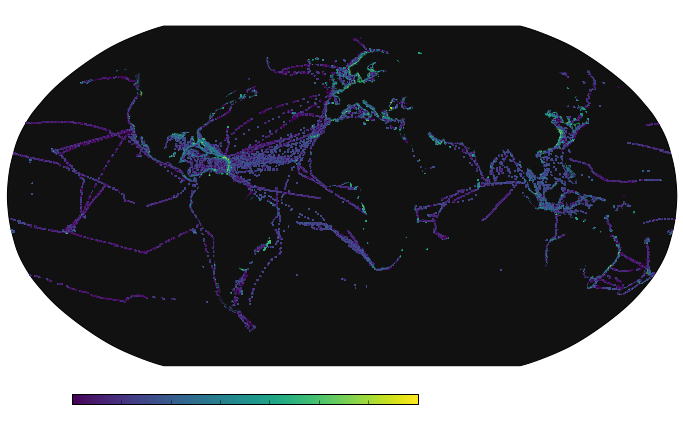

In [15]:
plt.rcParams["figure.figsize"] = [12,7]

cutoff = 0 # 4 degress away from the pole
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize

fishing_days_truncated = grid[one_over_cellsize*cutoff:(180*one_over_cellsize)-cutoff*one_over_cellsize][:]

numlats = int((firstlat-lastlat)*one_over_cellsize+.5)
numlons = int((lastlon-firstlon)*one_over_cellsize+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360*one_over_cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, fishing_days_truncated, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Density of "+vesselType+" in 2015"
plt.title(t, color = "#ffffff", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

the_labels = []
for l in lvls:
    if l>=1:
        l = int(l)
    the_labels.append(l)

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
cb.set_label('Vessel Density in 2015',labelpad=-40, y=0.45, color = "#ffffff")

ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='#ffffff', fontsize=6)

plt.savefig("../data/images/neural_classifier/vessel_density_"+vesselType+"_2015.png",bbox_inches='tight',dpi=150,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [37]:
def makeNerualRaster(vesselType):
    q = '''
    SELECT
      integer(FLOOR(lat*4)) lat_bin,
      integer(FLOOR(lon*4)) lon_bin,
      SUM(IF(last_timestamp IS NOT NULL, (timestamp-last_timestamp)/3600000000, (timestamp - TIMESTAMP(DATE(timestamp)))/3600000000)/2 + IF(next_timestamp IS NOT NULL, (next_timestamp - timestamp)/3600000000, ( TIMESTAMP(DATE(timestamp))- timestamp)/3600000000 +24 )/2) hours
    FROM (
      SELECT
        lat,
        lon,
        mmsi,
        timestamp,
        last_timestamp,
        next_timestamp,
        seg_id
      FROM
        TABLE_DATE_RANGE([pipeline_classify_logistic_661b_bined.], TIMESTAMP("2015-01-01"), TIMESTAMP("2015-01-31")))
    WHERE
      seg_id NOT IN (
      SELECT
        seg_id
      FROM
        [scratch_david_seg_analysis_661b.2015_segments]
      WHERE
        (point_count<20
          AND terrestrial_positions = point_count)
        OR ((min_lon >= 0 // these are almost definitely noise
            AND max_lon <= 0.109225)
          OR (min_lat >= 0
            AND max_lat <= 0.109225) ))
      AND mmsi IN (
      SELECT
        integer(mmsi) mmsi
      FROM
        [scratch_global_fishing_raster.classification_results_20160630]
      WHERE
        max_label_score>.8
        AND max_label_label = "'''+vesselType+'''" )
      AND lat < 90
      AND lat > -90
      AND lon > -180
      AND lon < 180
    GROUP BY
      lat_bin,
      lon_bin
    '''

    vessel_grid_query = Query(q)
    
    cellsize = .25
    one_over_cellsize = 4
    max_lat = 90
    min_lat = -90
    min_lon = -180
    max_lon = 180

    num_lats = (max_lat-min_lat)*one_over_cellsize
    num_lons = (max_lon-min_lon)*one_over_cellsize

    grid = np.zeros(shape=(num_lats,num_lons))

    for row in vessel_grid_query:
        lat = int(float(row[0]))
        lon = int(float(row[1]))
        lat_index = lat-min_lat*one_over_cellsize
        lon_index = lon-min_lon*one_over_cellsize
        grid[lat_index][lon_index] = float(row[2])
         
        plt.rcParams["figure.figsize"] = [4.5,3]

    cutoff = 0 # 4 degress away from the pole
    firstlat = 90-cutoff
    lastlat = -90+cutoff
    firstlon = -180
    lastlon = 180
    scale = cellsize

    fishing_days_truncated = grid[one_over_cellsize*cutoff:(180*one_over_cellsize)-cutoff*one_over_cellsize][:]

    numlats = int((firstlat-lastlat)*one_over_cellsize+.5)
    numlons = int((lastlon-firstlon)*one_over_cellsize+.5)

    lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
    lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

    fig = plt.figure()
    m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
              llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

    m.drawmapboundary(fill_color='#111111')
    # m.drawcoastlines(linewidth=.2)
    m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

    x = np.linspace(-180, 180, 360*one_over_cellsize)
    y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
    x, y = np.meshgrid(x, y)
    converted_x, converted_y = m(x, y)
    from matplotlib import colors,colorbar

    maximum = grid.max()
    minimum = 1

    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)

    m.pcolormesh(converted_x, converted_y, fishing_days_truncated, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

    t = "Density of "+vesselType+" in 2015"
    plt.title(t, color = "#ffffff", fontsize=9)

    ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

    the_labels = []
    for l in lvls:
        if l>=1:
            l = int(l)
        the_labels.append(l)

    #cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
    cb.ax.set_xticklabels(the_labels, fontsize=5, color = "#ffffff")
    cb.set_label('Vessel Density in 2015',labelpad=-30, y=0.45, color = "#ffffff", fontsize = 5)

    ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='#ffffff', fontsize=3)

    plt.savefig("../data/images/neural_classifier/vessel_density_"+vesselType.replace('/',"_")+"_2015.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
    plt.show()

Waiting on bqjob_r1acca597c5483260_00000155a7fdd73e_31 ... (0s) Current status: DONE   
Query time: 3.2349050045 seconds.


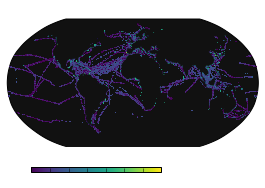

Waiting on bqjob_r1c7de278bfb2ca6f_00000155a7ff13af_32 ... (0s) Current status: DONE   
Query time: 2.4227180481 seconds.

In [ ]:
for vesselType in labels:
    makeNerualRaster(vesselType)